In [262]:
import copy
import random
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
from sklearn.metrics import confusion_matrix
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from torchsummary import summary
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter

In [263]:
class AddRandomNoise(object):
    def __init__(self, noise_range=(0, 0.3)):
        self.noise_range = noise_range

    def __call__(self, img):
        noise_level = random.uniform(self.noise_range[0], self.noise_range[1])
        noise = torch.randn_like(img) * noise_level
        return img + noise
    
training_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    AddRandomNoise(noise_range=(0, 0.2)),
])

train_ds = torchvision.datasets.MNIST(root='data', train=True, download=True, transform=training_transforms)
valid_ds = torchvision.datasets.MNIST(root='data', train=False, download=True, transform=transforms.ToTensor())

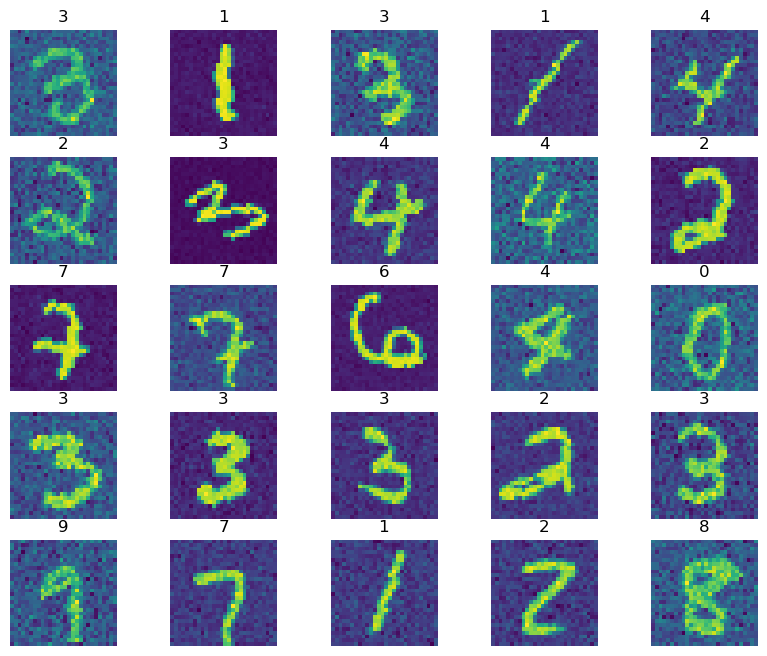

In [264]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_ds), size=(1,)).item()
    img, label = train_ds[sample_idx] # type: ignore
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="viridis")

In [265]:
# batch_size = 64
# train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
# valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

In [266]:
batch_size = 64
val_size = 0.1

# generate indices: instead of the actual data we pass in integers instead
train_indices, val_indices, _, _ = train_test_split(
    range(len(train_ds)),
    train_ds.targets,
    stratify=train_ds.targets,
    test_size=val_size,
)

# generate subset based on indices
train_split = Subset(train_ds, train_indices)
val_split = Subset(valid_ds, val_indices)

# create batches
train_dl = DataLoader(train_split, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(val_split, batch_size=batch_size, shuffle=True)

In [267]:
# in: 28x28
def create_model():
    return nn.Sequential(
        nn.Conv2d(
            in_channels=1,
            out_channels=8,
            kernel_size=6,
            stride=1,
            padding=3,
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(
            in_channels=8,
            out_channels=32,
            kernel_size=2,
            stride=1,
            padding=0,
        ),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=3, stride=3),
        nn.Flatten(),
        nn.Linear(in_features=512, out_features=100),
        nn.ReLU(),
        nn.Linear(in_features=100, out_features=10),
    )

In [268]:
# example_model = create_model()
# x = torch.zeros(1, 1, 28, 28)

# for m in example_model:
#     x = m(x)
#     print(m, x.size())

In [269]:
def validate(model, data, device):
    total = 0
    correct = 0
    for images, labels in data:
        images = images.to(device)
        labels = labels.to(device)

        x = model(images)
        _, pred = torch.max(x, 1)
        pred = pred.cpu()  # Move predictions back to CPU if they were on GPU
        total += labels.size(0)
        correct += torch.sum(pred == labels.cpu())  # Move labels back to CPU for comparison

    return correct * 100. / total

In [270]:
def train(numb_epoch=3, lr=0.05, device="cpu", log=True):
    accuracies = []
    best_model = cnn = create_model().to(device)
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    max_accuracy = 0
    max_acc_epoch = 0
    no_max = 0
    loss_value = 0
    for epoch in range(numb_epoch):
        for images, labels in train_dl:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = loss_func(pred, labels)
            loss.backward()
            optimizer.step()
            loss_value = loss.item()

        accuracy_test = float(validate(cnn, test_dl, device))
        accuracies.append(accuracy_test)
        scheduler.step(loss_value)
        if log:
            writer.add_scalar("Accuracy/Epoch", accuracy_test, epoch)
            writer.add_scalar("Learning rate/Epoch", optimizer.param_groups[0]["lr"], epoch)
            writer.add_scalar("Loss/Epoch", loss_value, epoch)
        if accuracy_test > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy_test
            max_acc_epoch = epoch
            print(f"-Saving Best Model with Accuracy: {accuracy_test}%, epoch: {max_acc_epoch}")
            if log:
                writer.add_scalar("New max/Epoch", no_max, epoch)
            no_max = 0
        else:
            no_max+=1
        print('Epoch:', epoch+1, "Test Accuracy :", accuracy_test, '%', "Learning rate: ", optimizer.param_groups[0]["lr"], "Loss", loss_value )
    plt.plot(accuracies)
    plt.plot(max_acc_epoch, max_accuracy, 'o')
    return best_model, max_accuracy

In [271]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("No Cuda Available")

No Cuda Available


-Saving Best Model with Accuracy: 97.9800033569336%, epoch: 0
Epoch: 1 Test Accuracy : 97.9800033569336 % Learning rate:  0.01 Train accuracy 0
-Saving Best Model with Accuracy: 98.05000305175781%, epoch: 1
Epoch: 2 Test Accuracy : 98.05000305175781 % Learning rate:  0.01 Train accuracy 0
-Saving Best Model with Accuracy: 98.7699966430664%, epoch: 2
Epoch: 3 Test Accuracy : 98.7699966430664 % Learning rate:  0.01 Train accuracy 0
Epoch: 4 Test Accuracy : 98.68000030517578 % Learning rate:  0.01 Train accuracy 0
-Saving Best Model with Accuracy: 98.9000015258789%, epoch: 4
Epoch: 5 Test Accuracy : 98.9000015258789 % Learning rate:  0.01 Train accuracy 0
Epoch: 6 Test Accuracy : 98.8499984741211 % Learning rate:  0.01 Train accuracy 0
-Saving Best Model with Accuracy: 98.91999816894531%, epoch: 6
Epoch: 7 Test Accuracy : 98.91999816894531 % Learning rate:  0.01 Train accuracy 0
Epoch: 8 Test Accuracy : 98.73999786376953 % Learning rate:  0.01 Train accuracy 0
Epoch: 9 Test Accuracy : 98.

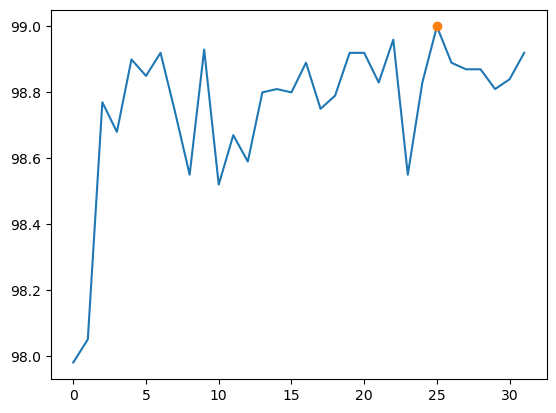

In [272]:
run_name = "04 - Use ReduceLROnPlateau scheduler"
writer = SummaryWriter(f'./runs/{run_name}')
model, max_accuracy = train(32, device=device, log=True) # type: ignore
writer.close()

In [273]:
ts = datetime.now().strftime('%Y%m%d%H%M%S')

torch.save(model.state_dict(), f'model_{ts}_{max_accuracy:0.3f}.pth')

In [274]:
def predict_dl(model, data):
    y_pred = []
    y_true = []
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        for images, labels in data:
            images = images.to(device)
            labels = labels.to(device)

            x = model(images)
            _, pred = torch.max(x, 1)
            pred = pred.data.cpu()
            
            correct_predictions += torch.sum(pred == labels.data.cpu()).item()
            total_samples += labels.size(0)

            y_pred.extend(list(pred.numpy()))
            y_true.extend(list(labels.numpy()))

    accuracy = (correct_predictions / total_samples) * 100.0

    return np.array(y_pred), np.array(y_true), accuracy

In [275]:
y_pred, y_true, test_accuracy = predict_dl(model, valid_dl)
print("Accuracy: ", test_accuracy, "%")
pd.DataFrame(confusion_matrix(y_true, y_pred, labels=np.arange(0,10)))

IndexError: index 28949 is out of bounds for dimension 0 with size 10000

In [ ]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 29, 29]             296
              ReLU-2            [-1, 8, 29, 29]               0
         MaxPool2d-3            [-1, 8, 14, 14]               0
            Conv2d-4           [-1, 32, 13, 13]           1,056
              ReLU-5           [-1, 32, 13, 13]               0
         AvgPool2d-6             [-1, 32, 4, 4]               0
           Flatten-7                  [-1, 512]               0
            Linear-8                  [-1, 100]          51,300
              ReLU-9                  [-1, 100]               0
           Linear-10                   [-1, 10]           1,010
Total params: 53,662
Trainable params: 53,662
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 0.20
Estimated Tot